# <font color = "\#8FBC8F">**Initialization**


In [176]:
#@title <font color="\#8FBC8F">Google Drive mount
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [177]:
#@title <font color="\#8FBC8F">Imports
import os
import pdb
from datetime import datetime as dt

from tqdm import tqdm
from pprint import pprint as pp

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import csv
import pickle

import warnings
warnings.filterwarnings("ignore")

print('[imports successfully loaded]')

[imports successfully loaded]


In [178]:
#@title <font color="\#8FBC8F">ML Imports 
# from sklearn.preprocessing import StandardScaler as NRM

from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb


from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_validate
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, roc_curve, roc_auc_score, f1_score, precision_recall_curve
from sklearn.metrics import classification_report as CR

# from scipy.stats import uniform, randint

# <font color=cyan>Subject number

In [179]:

#@title <font color="\#8FBC8F">File loading utility code
DATA_DIR = r'/content/drive/MyDrive/Colab Notebooks/Project Domino/new Macros/'
subject_list = sorted([f for f in os.listdir(DATA_DIR) if 'sub' in f])

subject_index = 5#@param {type:'integer'} 

subject_path = DATA_DIR + f'{subject_list[subject_index]}/'
subject_files = os.listdir(subject_path)

if 'sub' not in locals() or sub != subject_list[subject_index]:
    sub = subject_list[subject_index] 

ch_name_file = DATA_DIR+f'/{sub}/{sub}_channel_names.npy'
channel_names = np.load(ch_name_file)

print(f'[Working on {subject_list[subject_index]}]')


[Working on sub-016]





# <font color = "\#8FBC8F">**Loading Data**</font> 





In [180]:
#@title <font color='darkgreen'>Unpickle X and y - Utility
pickle_path = f'/content/drive/MyDrive/Colab Notebooks/Project Domino/Feature-Label matrices/{sub}/'
f_last = pickle_path + [f for f in os.listdir(pickle_path) if 'last' in f][0]

with open(f_last, 'r') as f: last_date = f.read()
results_path = pickle_path + last_date

if not 'best params' in os.listdir(results_path): 
    os.mkdir(results_path + '/best params')
    print('[\"best params\" Folder Created]')
else: print('[\"best params\" Folder Exists]')

_X = pd.read_pickle(results_path +'/X.pickle')
_y = pd.read_pickle(results_path +'/y.pickle')
X, y = _X, _y

print('[Data loaded successfully]')


["best params" Folder Exists]
[Data loaded successfully]


In [181]:
#@title Function and dictionaries declaration
global seed

def split_norm(X):
    X_train, X_test, y_train, y_test = Split(X, y, test_size=0.2, random_state=seed)
    
    nrm = NRM().fit(X_train)
    X_train = pd.DataFrame(nrm.transform(X_train), columns=X.columns)
    X_test = pd.DataFrame(nrm.transform(X_test), columns=X.columns)
    return X_train, X_test, y_train, y_test

def train_models(X_train, X_test, y_train, y_test):
    svc = LinearSVC().fit(X_train, y_train.to_numpy().ravel())
    knn = KNeighborsClassifier().fit(X_train, y_train.to_numpy().ravel())
    lr = LogisticRegressionCV().fit(X_train, y_train.to_numpy().ravel())
    gb = GradientBoostingClassifier().fit(X_train, y_train.to_numpy().ravel())
    return svc, knn, lr, gb
    # return [svc]
    # return [knn]
    # return [lr]
    # return [gb]



def plot_conf_mxs(models, X_test, y_test, plot=False):
    for mdl in models:
        mdl_name = mdl.__str__().split('(')[0]
        
        if plot:
            disp = plot_confusion_matrix(mdl, X_test, y_test)
            disp.figure_.set_size_inches([3,3])
            disp.ax_.set_title(mdl_name)
            cnf = disp.confusion_matrix
        else:
            cnf = confusion_matrix(y_test,mdl.predict(X_test))

        return (channel_names[channel_number], mdl_name, cnf)

    # return confusion_matrices



def report_models(models, X_test, y_test, prnt=True):
    reports = []
    for mdl in models:
        mdl_name = mdl.__str__().split('(')[0]
        cr = CR(y_test,mdl.predict(X_test),output_dict=True)
        if prnt:
            print(f'{mdl_name} - classification report '+'*'*(60-len(mdl_name))+'\n')
            print(cr)
            print('*'*(60+len(' - classification report '))+'\n')
        reports.append((channel_names[channel_number], mdl_name, cr['macro avg']))
    return reports

In [182]:
split = False #@param {type:'boolean'}
test_size = 0.2 #@param
if split:
    X_train, X_test, y_train, y_test = train_test_split(_X, _y, test_size=test_size)
else: X_train, y_train = _X, _y

In [183]:
#@title Setting up X
channel_number =  27#@param {type:'integer'}

X = X_train.xs(key=channel_number, axis=1, level='Channel_Number')

# Decision tree


In [184]:
#@title DT params
params_path = results_path + '/best params'

# print(os.listdir(params_path))
df = pd.read_csv(params_path + '/DecisionTreeClassifier_summary.csv')
_params = df.iloc[0].to_dict().copy()
params = _params
del params['ch_number'], params['f1-score']
params = {k:int(v) for k,v in params.items()}
params

{'max_depth': 14, 'min_samples_leaf': 1, 'min_samples_split': 2}

In [185]:
#@title DT Model and CV declaration
model = DecisionTreeClassifier(**params)

cv = cross_validate(model,X,y_train, scoring='f1', return_estimator=True)


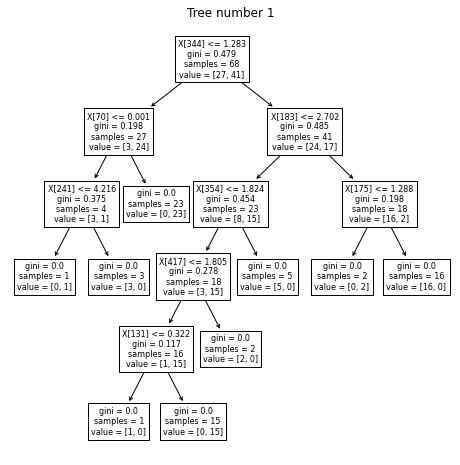

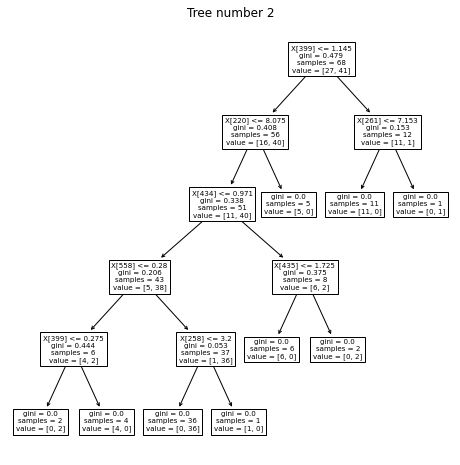

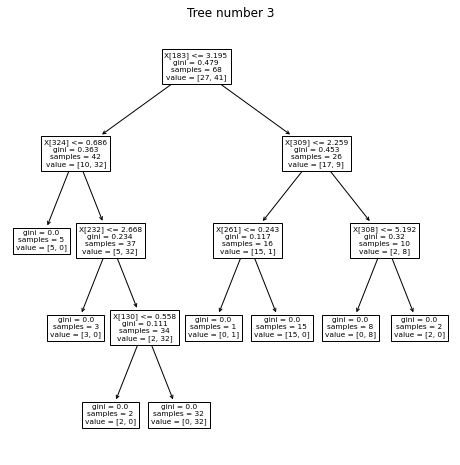

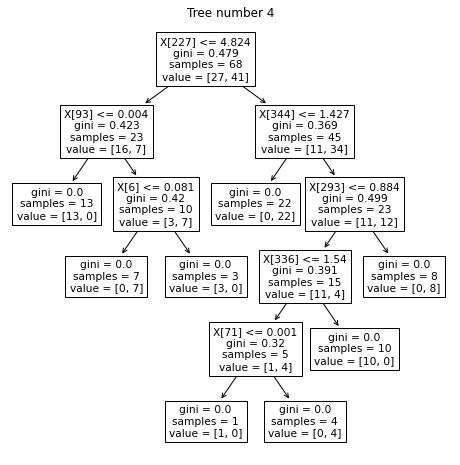

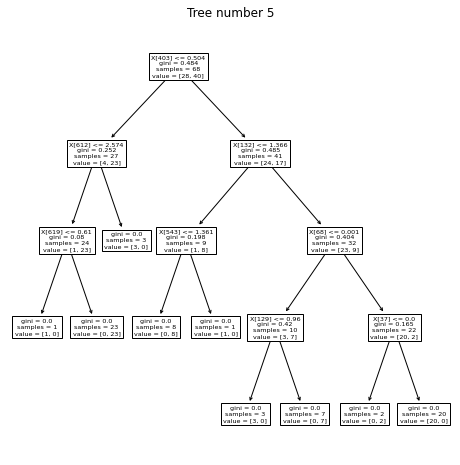

In [186]:
#@title DT vis
from sklearn.tree import plot_tree

vis = True #@param {type:'boolean'}
if vis:
    for i, tree in enumerate(cv['estimator']):
        plt.figure(figsize=(8,8))
        plot_tree(tree)
        _ = plt.title(f'Tree number {i+1}')


In [187]:
#@title Get Features used in all CV estimators
features = np.concatenate([est.tree_.feature for est in cv['estimator']])
irr = np.where(features == -2)
features = np.delete(features, irr)
print(features)


[344  70 241 183 354 417 131 175 399 220 434 558 399 258 435 261 183 324
 232 130 309 261 308 227  93   6 344 293 336  71 403 612 619 132 543  68
 129  37]


In [188]:
#@title DT CV Best Features
X.columns[features]


MultiIndex([(  'mean',  'low-Gamma', 1600),
            (   'min',       'Beta', 1400),
            (   'max', 'high-Gamma', 2000),
            (   'max',      'Alpha', 3000),
            (  'mean',  'low-Gamma', 3600),
            (   'std',      'Theta', 3600),
            (   'max',      'Delta', 1000),
            (   'max',      'Alpha', 1400),
            (   'std',      'Theta',    0),
            (   'max',  'low-Gamma', 2000),
            (   'std',      'Alpha', 2800),
            ('median',      'Alpha', 2400),
            (   'std',      'Theta',    0),
            (  'mean',      'Delta', 1200),
            (   'std',      'Alpha', 3000),
            (  'mean',      'Delta', 1800),
            (   'max',      'Alpha', 3000),
            (  'mean',       'Beta', 1800),
            (   'max', 'high-Gamma',  200),
            (   'max',      'Delta',  800),
            (  'mean',      'Alpha', 3000),
            (  'mean',      'Delta', 1800),
            (  'mean',      'Alp

# XGBoost

In [189]:
#@title load XGB params
params_path = results_path + '/best params'

# print(os.listdir(params_path))
df = pd.read_csv(params_path + '/XGBClassifier_summary.csv')
_params = df.iloc[0].to_dict().copy()
params = _params
del params['ch_number'], params['f1-score']
# params = {k:int(v) for k,v in params.items()}
params['max_depth'] = int(params['max_depth'])
params['n_estimators'] = int(params['n_estimators'])

params

{'colsample_bynode': 0.7,
 'colsample_bytree': 0.8,
 'learning_rate': 0.05,
 'max_depth': 3,
 'n_estimators': 250,
 'reg_alpha': 0.15,
 'subsample': 0.9}

In [190]:
#@title XGB Model declaration
model = xgb.XGBClassifier(**params)

model.fit(X,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=0.7, colsample_bytree=0.8, gamma=0,
              learning_rate=0.05, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=250, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0.15, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.9, verbosity=1)

In [191]:
#@title Create XGB no-CV feature importance dict
feats = np.where(model.feature_importances_ > 0)
columns = X.columns[feats].tolist()
imps = model.feature_importances_[feats]

features = {c:i for c,i in zip(columns, imps)}
# features


In [192]:
#@title Create XGB CV feature importance dictionary
cv = cross_validate(model,X,y_train, scoring='f1', return_estimator=True)

cv_features = {}

for est,score in zip(cv['estimator'],cv['test_score']):
    fts = np.where(est.feature_importances_ > 0)
    
    cols = X.columns[fts].tolist()
    ims = est.feature_importances_[fts]
    
    for c in cols: 
        if c not in cv_features.keys(): cv_features[c] = 0

    for c,i in zip(cols,ims):
        cv_features[c] += i*score

# cv_features

# Plot results



In [193]:
#@title Create X-like data structure
mock_X = X.copy()

for c in mock_X.columns:
    mock_X[c] = 0

cv_results = True #@param {type:'boolean'}

if cv_results: plot_features = cv_features 
else: plot_features = features 

for k,v in plot_features.items():
    mock_X[k] = v
mock_X = mock_X.loc[0]

In [194]:
#@title Util.
grp = mock_X.groupby(lambda i:i[0]).groups
bins = [[bin[1:]] for bin in [*grp[[*grp.keys()][0]]]]
max_weight = mock_X.groupby(lambda i:i[0]).max()


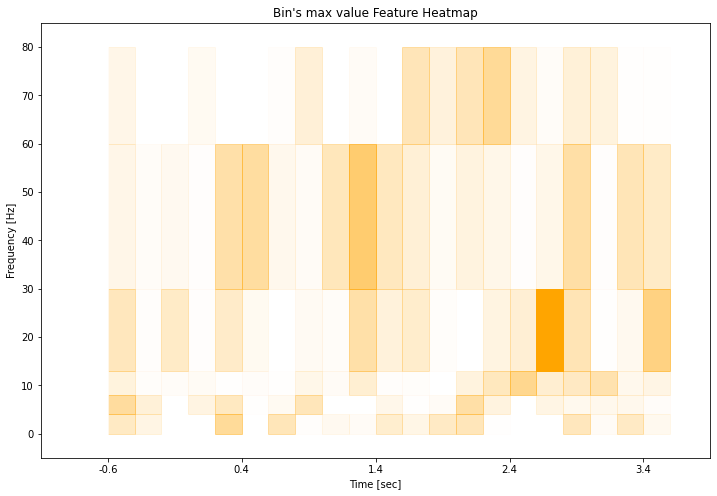

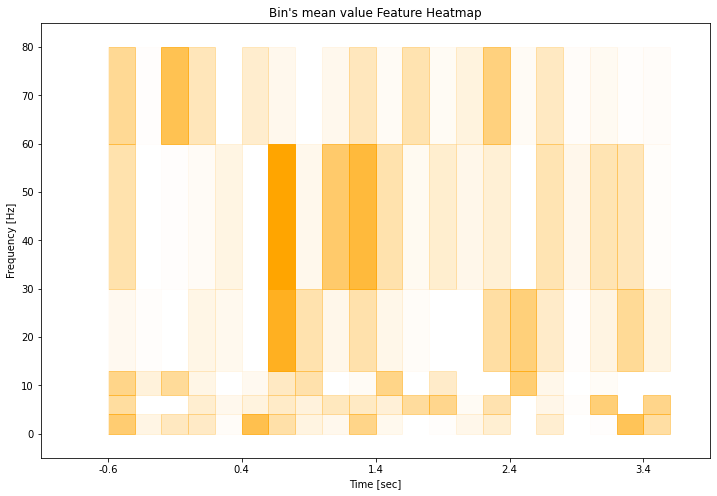

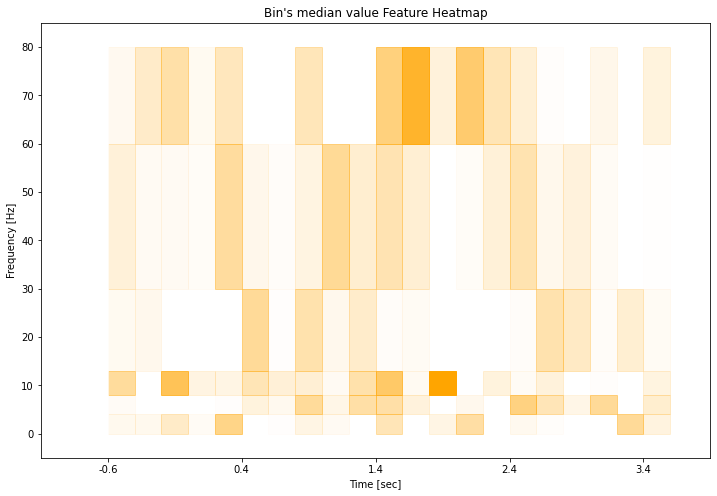

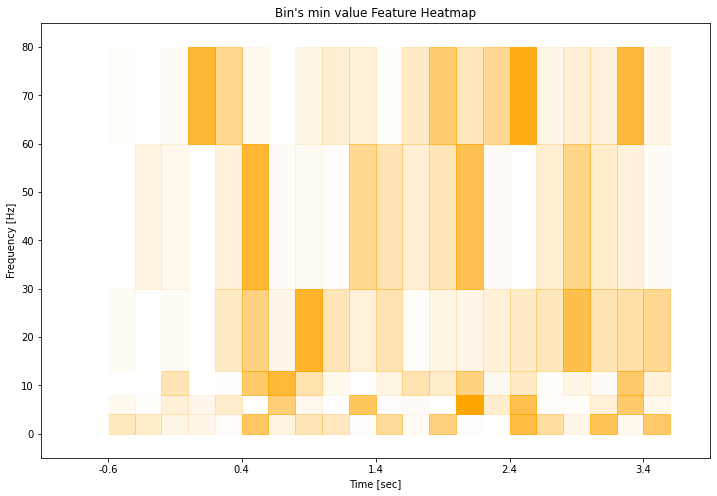

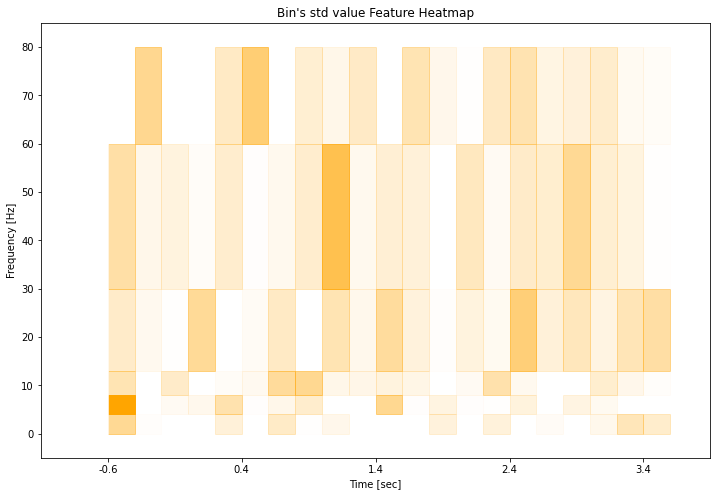

In [195]:
#@title Plots
from matplotlib.patches import *
f_names = ['Delta', 'Theta', 'Alpha', 'Beta', 'low-Gamma', 'high-Gamma']
f_bands = [0, 4, 8, 13, 30, 60, 80]
name_to_ylim = {name: (f_bands[i],f_bands[i+1]) for i,name in enumerate(f_names)}
dt = 200

def get_mpl_rect(band, T0, alpha):
    ylim = name_to_ylim[band]
    
    width = dt
    heigth = ylim[1]-ylim[0]
    
    xy = (T0, ylim[0])

    return Rectangle(xy,width, heigth, alpha=alpha, color='orange')


for k,v in grp.items():
    fig, ax = plt.subplots(figsize=(12,8))
    ax.plot([0,0],[0,80], c='white')
    
    # plot the ROI's
    for X_key in grp[k]:
        X_val = mock_X[X_key]
        if X_val >0: 
            # print(X_key[0],X_val)
            alpha = X_val/max_weight[X_key[0]]
            rect = get_mpl_rect(*X_key[1:], alpha)
            ax.add_patch(rect)

    plt.xlim((-500, 4500))
    plt.ylim((-5, 85))

    # X labels correction
    locs, labels = plt.xticks()   
    

    ax.set_xticklabels(((locs/1000) - 0.6).round(2))
    
    # Titles
    ax.set_title(f'Bin\'s {k} value Feature Heatmap')
    plt.xlabel('Time [sec]')
    plt.ylabel('Frequency [Hz]')


    


# Plot results



In [196]:
#@title Create X-like data structure
mock_X = X.copy()

for c in mock_X.columns:
    mock_X[c] = 0

cv_results = False #@param {type:'boolean'}

if cv_results: plot_features = cv_features 
else: plot_features = features 

for k,v in plot_features.items():
    mock_X[k] = v
mock_X = mock_X.loc[0]

In [197]:
#@title Util.
grp = mock_X.groupby(lambda i:i[0]).groups
bins = [[bin[1:]] for bin in [*grp[[*grp.keys()][0]]]]
max_weight = mock_X.groupby(lambda i:i[0]).max()


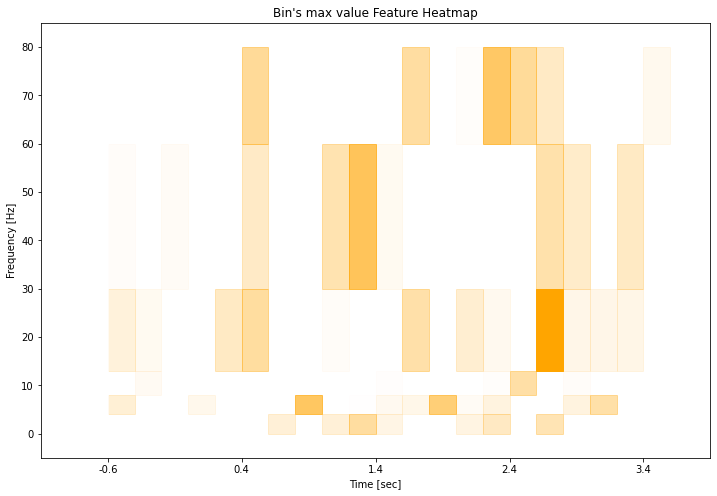

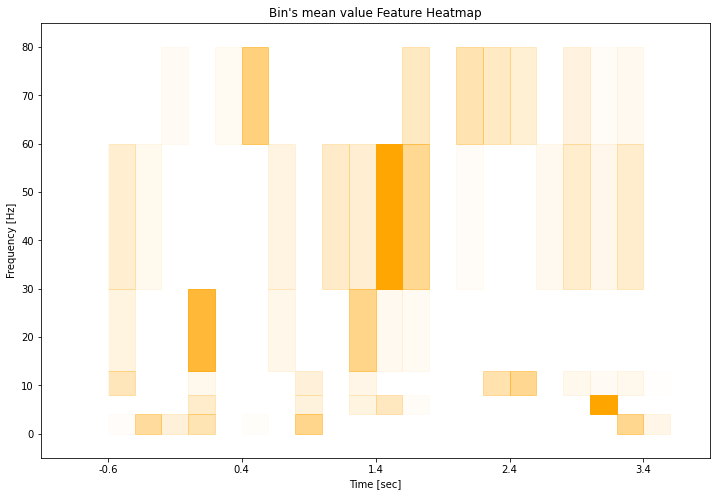

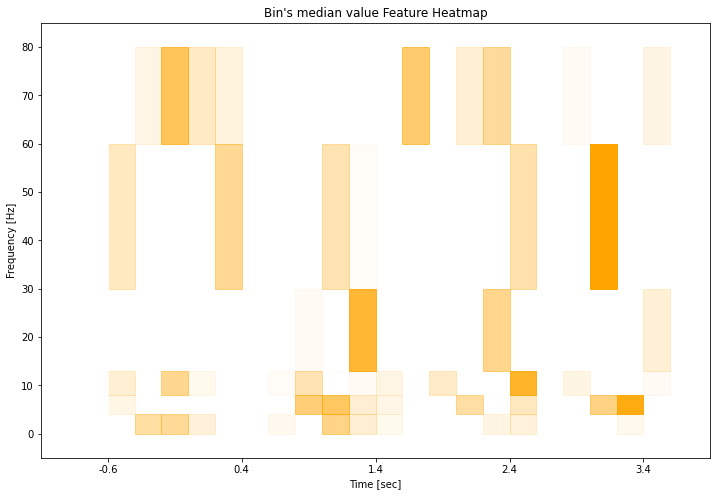

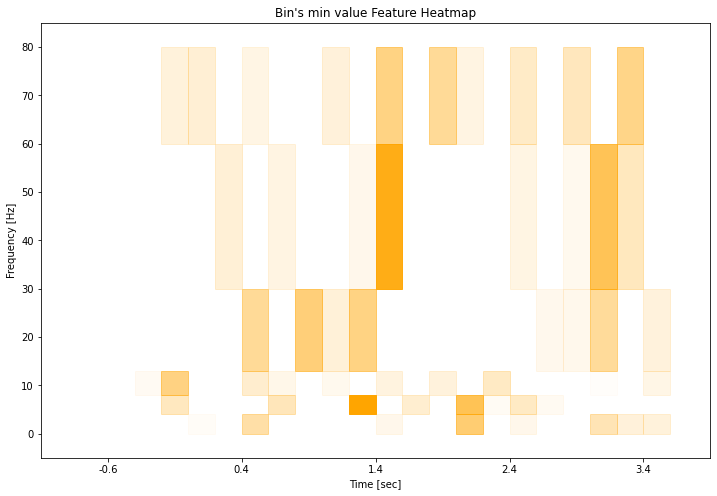

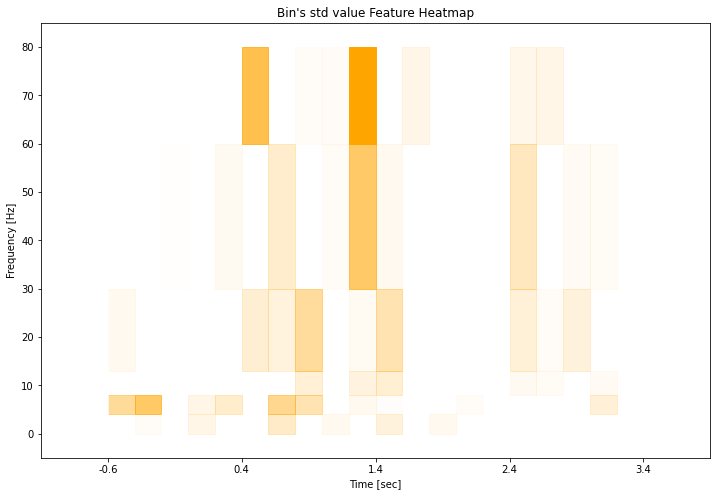

In [198]:
#@title Plots
from matplotlib.patches import *
f_names = ['Delta', 'Theta', 'Alpha', 'Beta', 'low-Gamma', 'high-Gamma']
f_bands = [0, 4, 8, 13, 30, 60, 80]
name_to_ylim = {name: (f_bands[i],f_bands[i+1]) for i,name in enumerate(f_names)}
dt = 200

def get_mpl_rect(band, T0, alpha):
    ylim = name_to_ylim[band]
    
    width = dt
    heigth = ylim[1]-ylim[0]
    
    xy = (T0, ylim[0])

    return Rectangle(xy,width, heigth, alpha=alpha, color='orange')


for k,v in grp.items():
    fig, ax = plt.subplots(figsize=(12,8))
    ax.plot([0,0],[0,80], c='white')
    
    # plot the ROI's
    for X_key in grp[k]:
        X_val = mock_X[X_key]
        if X_val >0: 
            # print(X_key[0],X_val)
            alpha = X_val/max_weight[X_key[0]]
            rect = get_mpl_rect(*X_key[1:], alpha)
            ax.add_patch(rect)

    plt.xlim((-500, 4500))
    plt.ylim((-5, 85))

    # X labels correction
    locs, labels = plt.xticks()   
    

    ax.set_xticklabels(((locs/1000) - 0.6).round(2))
    
    # Titles
    ax.set_title(f'Bin\'s {k} value Feature Heatmap')
    plt.xlabel('Time [sec]')
    plt.ylabel('Frequency [Hz]')


    


# Mean Wavelet Plotting

In [199]:
import os
import numpy as np
import matplotlib.pyplot as plt

erp_path = f'/content/drive/MyDrive/Colab Notebooks/Project Domino/new Macros/sub-017/'

os.listdir(erp_path)
l0_fname = 'sub-017_label_0_match_mean.npy'
l1_fname = 'sub-017_label_1_non-match_mean.npy'

l0 = np.load(erp_path+l0_fname)
l1 = np.load(erp_path+l1_fname)

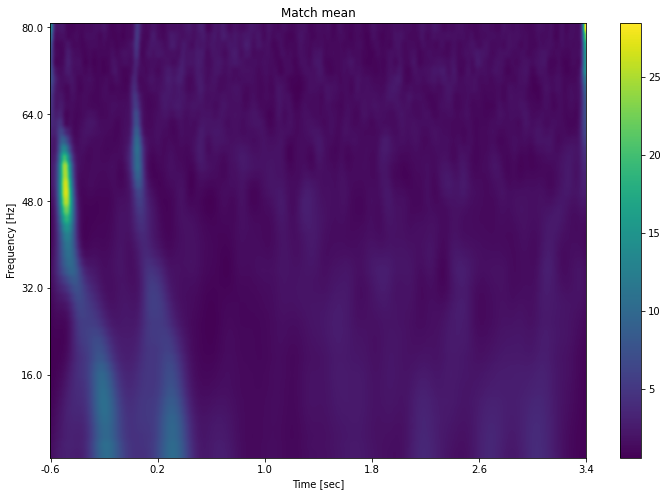

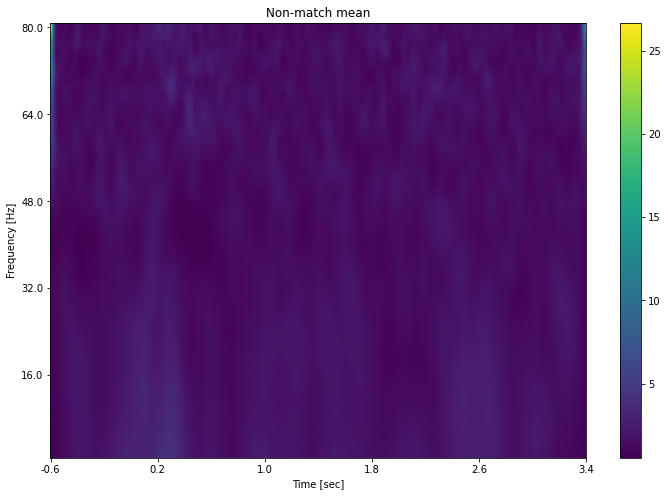

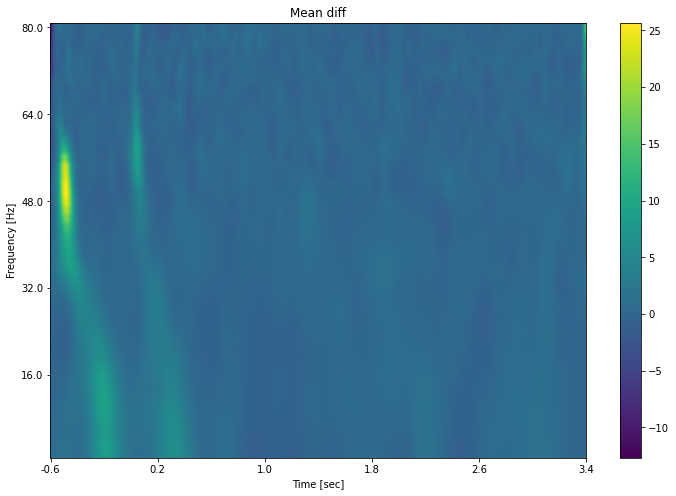

In [200]:
def plot_wt(l, fname):
    plt.figure(figsize=(12,8))
    ax = plt.imshow(l[channel_number], aspect='auto')

    locs, _ = plt.xticks()
    ax.axes.set_xticklabels(((locs/250) - 0.6).round(2))
    freqs, labels = plt.yticks()
    # print(freqs)
    # print(labels)
    real_freqs = [str(i) for i in np.linspace(0,80,6)][::-1]
    ax.axes.set_yticklabels(labels=[0, *real_freqs])

    plt.colorbar()
    # plt.clim([-2, 5])
    plt.title(' '.join(fname.split('_')[3:])[:-4].capitalize())
    plt.xlabel('Time [sec]')
    _ = plt.ylabel('Frequency [Hz]')


plot_wt(l0,l0_fname)
plot_wt(l1,l1_fname)

plot_wt(l0-l1, 'sub-017_label_0_mean_diff.npy')